# 10-year Yields through time

Equity investments are supposed to be for the *long-term*. Usually, 10-years is where most investors peg their *long-term* to be. Investors have a choice between different asset classes - stocks/bonds/gold etc. With government/sovereign bonds, you know the yield (return) you can lock in, risk-free, for a decade, today. Since equities are riskier, investors demand higher returns - the equity risk premium - over 10-year sovereign bond yields for their *long-term* investments. This is why tracking the 10-year yield is important for equity investors - it denotes a floor for expected equity returns. Investors would be rational investors in equities only if they felt that it provides adequate excess returns over 10-year bonds, over the *long-term*.

Here, we plot the 10-year yields of US tresuries, Euro Area AAA rated soverigns and Indian Gsecs.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices <- Indices() #for IndiaGsecTimeSeries
ycurves <- YieldCurve() #for UsTreasury, EuroArea 

In [6]:
startDate <- as.Date("2004-01-01")
# https://plutopy.readthedocs.io/en/latest/Indices.html#plutoPy.model.Indices.IndiaGsecTimeSeries
ycInd <- indices$IndiaGsecTimeSeries() %>%
    filter(NAME == "5_10" & TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = YTM) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

# https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.UsTreasury
ycUst <- ycurves$UsTreasury() %>%
    filter(TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = Y10) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

# https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.EuroArea
ycEuro <- ycurves$EuroArea() %>%
    filter(TENOR_Y == 10 & TENOR_M == 0 & CURVE_ID == 'G_N_A' & TIME_STAMP >= startDate) %>%
    select(TIME_STAMP, YIELD = VALUE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [7]:
allYc <- ycInd %>% 
            full_join(ycUst, by=c('TIME_STAMP')) %>% 
            full_join(ycEuro, by=c('TIME_STAMP')) %>% 
            fill(YIELD, YIELD.x, YIELD.y) %>%
            arrange(TIME_STAMP) %>%
            as.data.frame()

names(allYc) <- c('TIME_STAMP', 'INDIA', 'US', 'EURO')

print(head(allYc))
print(tail(allYc))

  TIME_STAMP  INDIA   US EURO
1 2004-01-01 5.1030   NA   NA
2 2004-01-02 5.0982 4.38   NA
3 2004-01-03 5.0870 4.38   NA
4 2004-01-04 5.0856 4.38   NA
5 2004-01-05 5.0996 4.41   NA
6 2004-01-06 5.0858 4.29   NA
     TIME_STAMP  INDIA   US    EURO
5727 2019-09-07 6.6372 1.55 -0.5875
5728 2019-09-08 6.6368 1.55 -0.5875
5729 2019-09-09 6.6306 1.63 -0.5298
5730 2019-09-10 6.6302 1.72 -0.5260
5731 2019-09-11 6.6613 1.75 -0.5217
5732 2019-09-12 6.6842 1.79 -0.5217


In [8]:
plotLines <- function(plotData){
    startDate <- first(plotData$TIME_STAMP)
    endDate <- last(plotData$TIME_STAMP)

    xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

    toPlot <- melt(plotData, id='TIME_STAMP')

    ggplot(toPlot, aes(x = TIME_STAMP, y=value, color=variable)) + 
        theme_economist() +
        geom_line() + 
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y='yield (%)', fill='', color='',
             title="10-year Sovereign Yields", 
             subtitle=sprintf("[%s:%s]", startDate, endDate)) +
        annotate("text", x=startDate, y=min(toPlot$value, na.rm=T), label = "@StockViz", 
                 hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)
}    

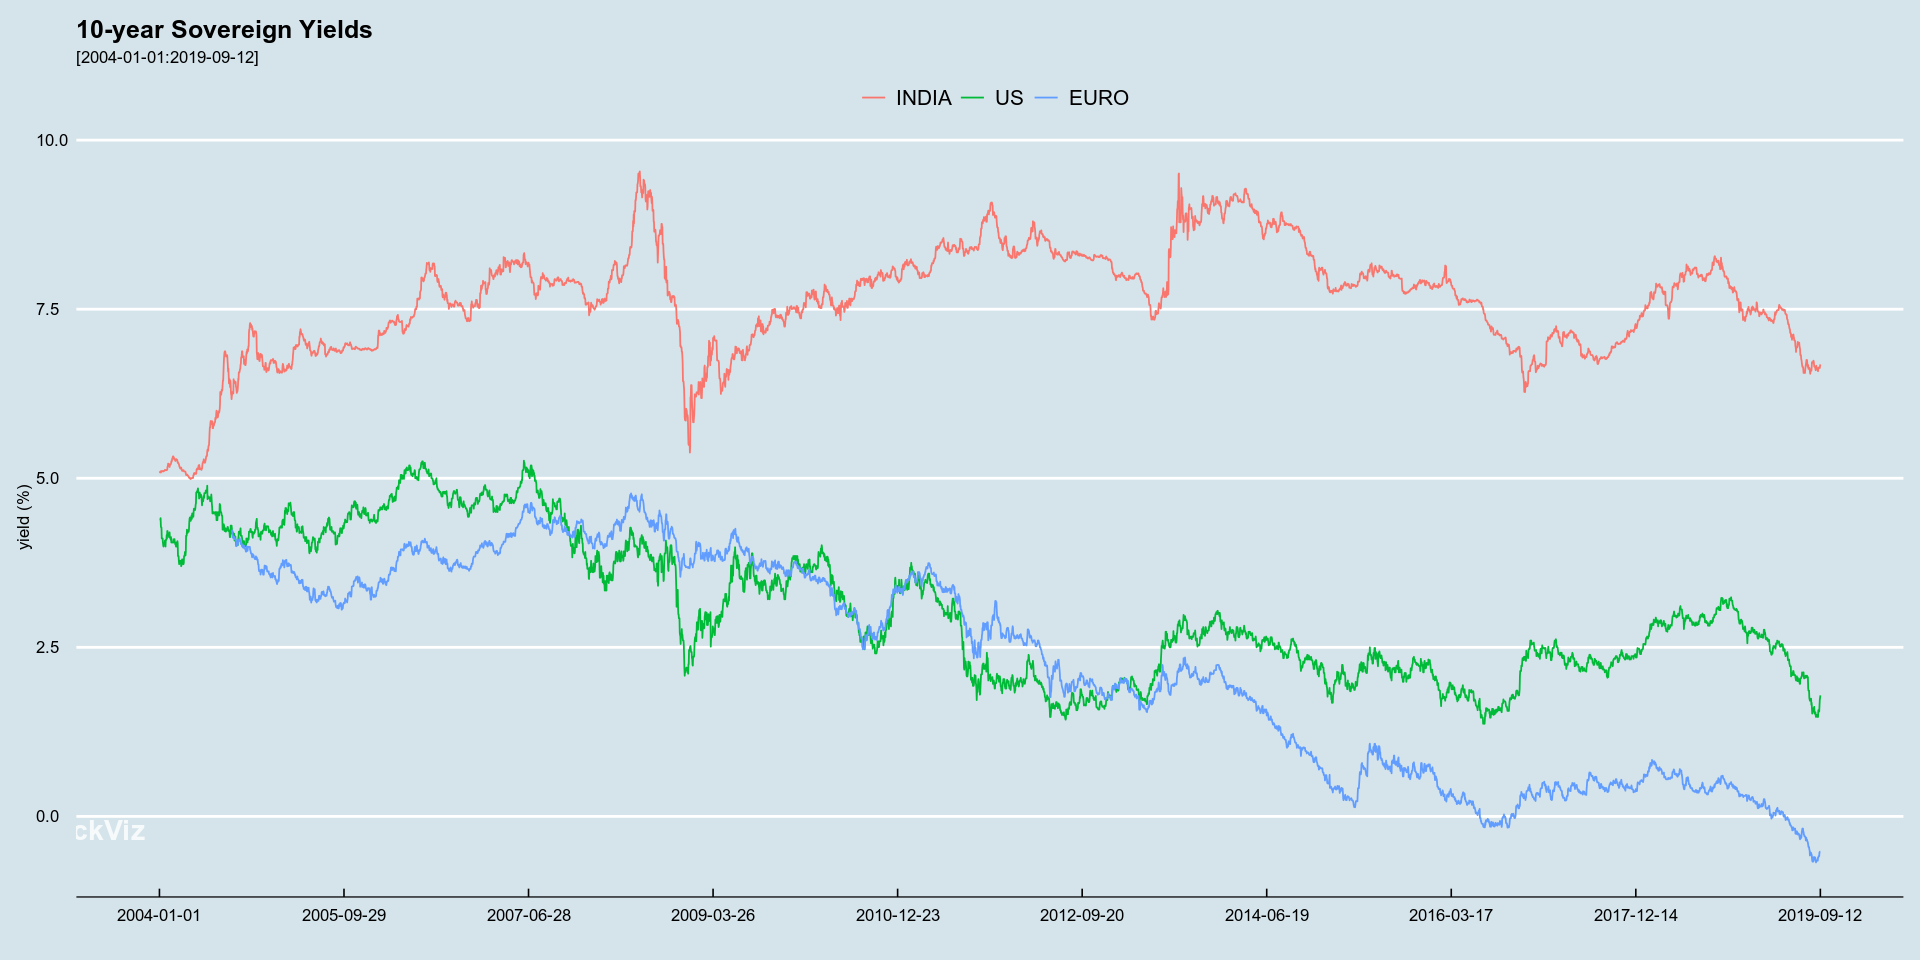

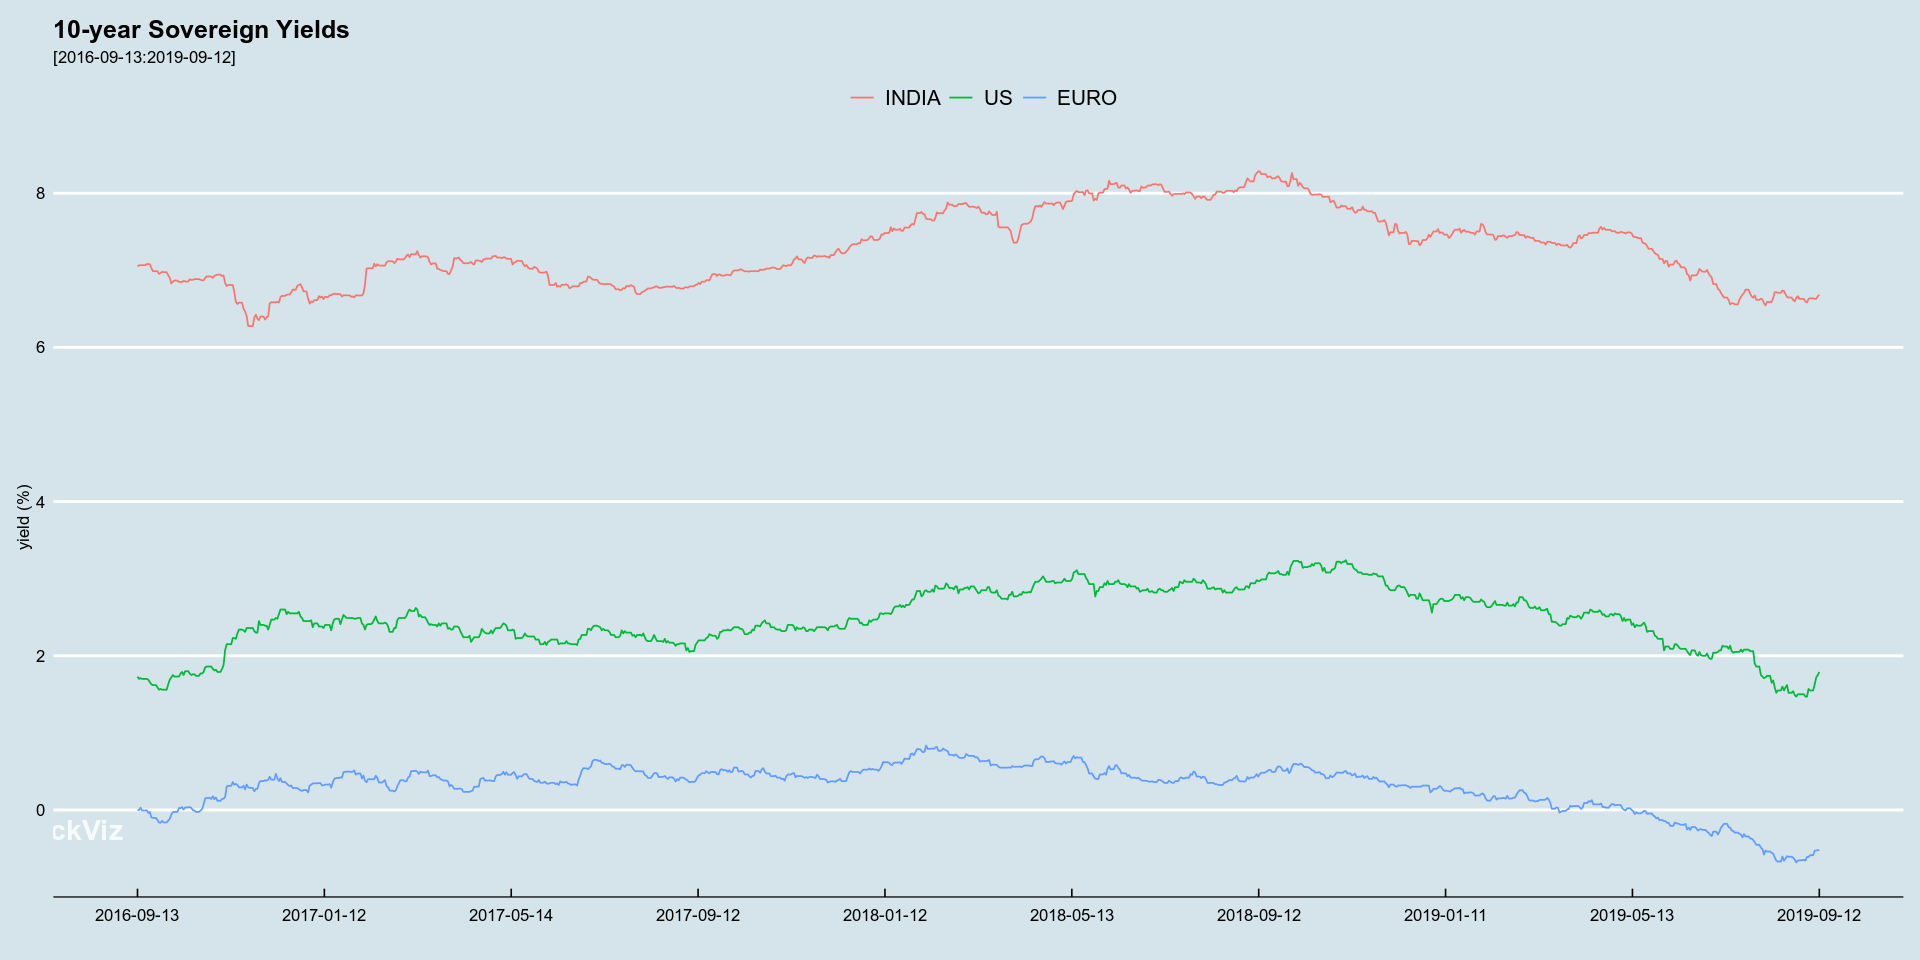

In [9]:
# plot the whole thing

plotLines(allYc)

# zoom in to the last 3 years

startNew <- as.Date(Sys.Date() - 3*365)
allYcNew <- allYc[allYc$TIME_STAMP >= startNew,]

plotLines(allYcNew)

Does this mean the European investors would be happy even with zero equity returns over the next 10 years? US investors with 2%? Indian investors with ~6%?

Well, thats what a cursory look at the 10-year yields seem to indicate.

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)